# Quantum Teleportation

## The circuit

In this first lab lecture we will see how to simulate quantum teleportation using `Qiskit`.

First, let's create the quantum circuit we need:

In [15]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

# one register of 3 qubits
qr1 = QuantumRegister(2, name='a')
qr2 = QuantumRegister(1, name='b')
# 2 registers of 1 bit each
cr1 = ClassicalRegister(1, name='cr1')
cr2 = ClassicalRegister(1, name='cr2')
# quantum circuit
teleportation_circuit = QuantumCircuit(qr1, qr2, cr1, cr2)

In order to do teleportation we must give Alice and Bob an entangled pair.

In [16]:
def bellPair(qc, a, b):
    '''
    Creates a bell pair in qc using qubits a & b
    '''
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

<IPython.core.display.Latex object>

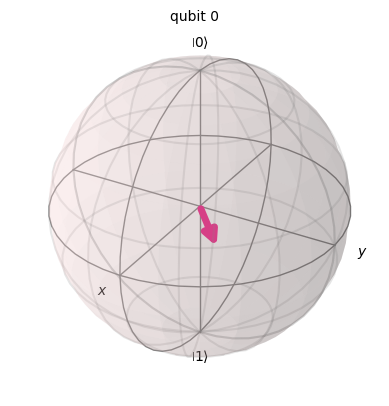

In [17]:
from qiskit.quantum_info import random_statevector
from qiskit.visualization import array_to_latex, plot_bloch_multivector

# Initialize a random state
psi = random_statevector(2)
# Display it nicely
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
# Show it on a Bloch sphere
plot_bloch_multivector(psi)

Let's initialize $|\psi \rangle$ starting from $|0 \rangle$. Notice that `Initialize` is technically not a gate since it contains a reset operation, so it's not invertible.

In [18]:
from qiskit.extensions import Initialize

teleportation_circuit.append(Initialize(psi), [0])

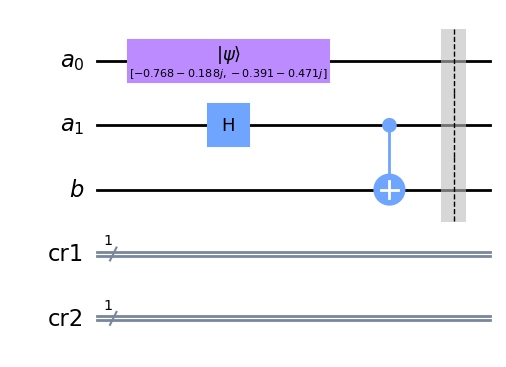

In [19]:
bellPair(teleportation_circuit, 1, 2)
teleportation_circuit.barrier()
teleportation_circuit.draw(output='mpl')

Now Alice and Bob shares the entangled couple $|a_1 \rangle$, $|b \rangle$.

The goal of Alice is to send the qubit $|a_0 \rangle$ to Bob.
In order to do this, Alice will do:

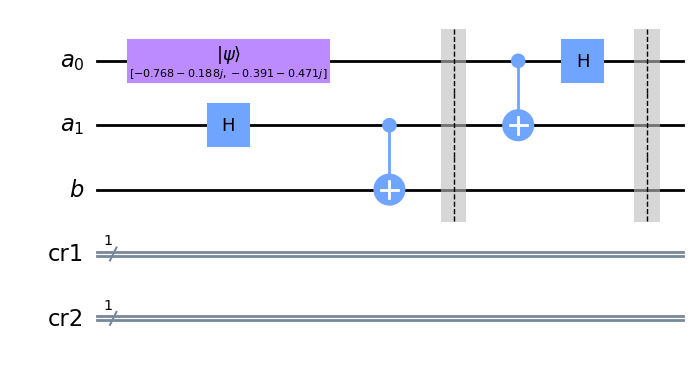

In [20]:
teleportation_circuit.cx(0,1)
teleportation_circuit.h(0)
teleportation_circuit.barrier()
teleportation_circuit.draw(output='mpl')

Now, Alice needs to send also two classical bits to Bob in order to permit him to adjust the received bit.

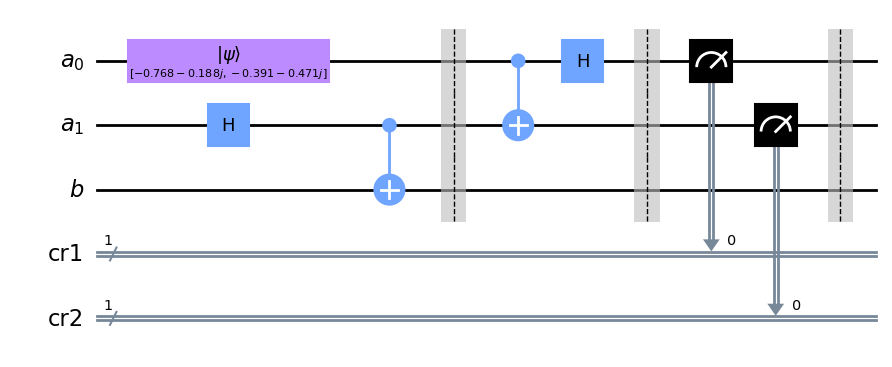

In [21]:
teleportation_circuit.measure(0,0)
teleportation_circuit.measure(1,1)
teleportation_circuit.barrier()
teleportation_circuit.draw(output='mpl')

At this moment Bob has all he needs in order to get the original state $|a_0 \rangle$.

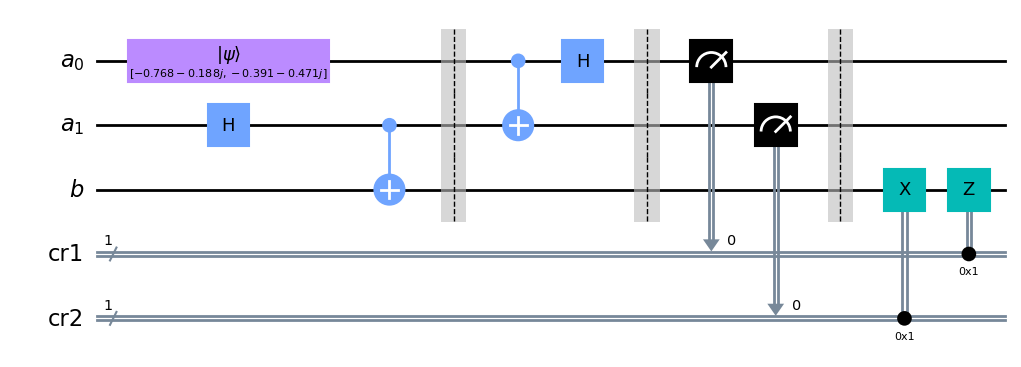

In [22]:
teleportation_circuit.x(2).c_if(cr2, 1)
teleportation_circuit.z(2).c_if(cr1, 1)
teleportation_circuit.draw(output='mpl')

<IPython.core.display.Latex object>

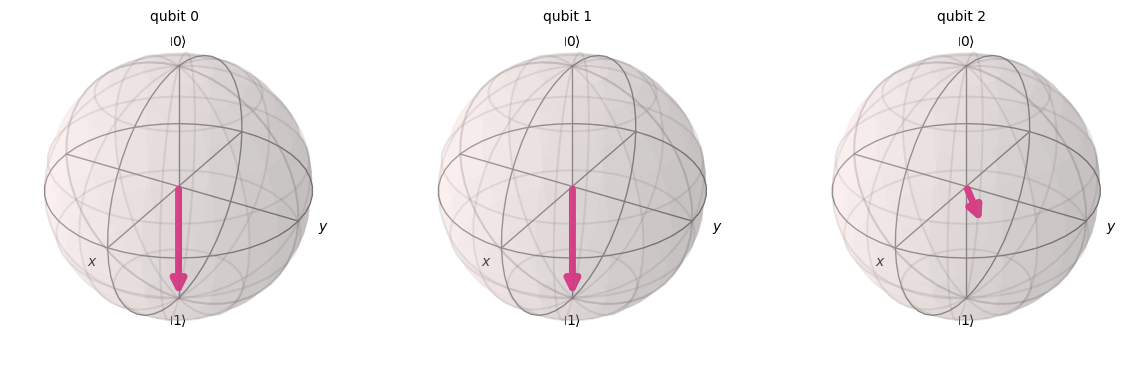

In [23]:
from qiskit import Aer
import numpy as np

simulator = Aer.get_backend('statevector_simulator')
result = simulator.run(teleportation_circuit).result()
psi_out = result.get_statevector()

display(array_to_latex(psi_out, prefix="|\\psi\\rangle ="))
plot_bloch_multivector(psi_out)

The circuit is complete: Alice's qubit has correctly been sent to Bob.

Let's save the circuit in a function, in order to reuse it.

In [24]:
def tpCircuit(initState = None):
    '''
    Returns a teleportation circuit with the given initial state
    '''
    qr1 = QuantumRegister(2, name='a')
    qr2 = QuantumRegister(1, name='b')
    cr1 = ClassicalRegister(1, name='cr1')
    cr2 = ClassicalRegister(1, name='cr2')
    cr3 = ClassicalRegister(1, name='Bob\'s measure')
    qc = QuantumCircuit(qr1, qr2, cr1, cr2, cr3)
    if initState is not None:
        qc.append(initState, [0])
    else:
        qc.x(0)
    bellPair(qc, 1, 2)
    qc.cx(0,1)
    qc.h(0)
    qc.barrier()
    qc.measure(0,0)
    qc.measure(1,1)
    qc.x(2).c_if(cr2, 1)
    qc.z(2).c_if(cr1, 1)
    return qc

## Simulate the teleportation protocol

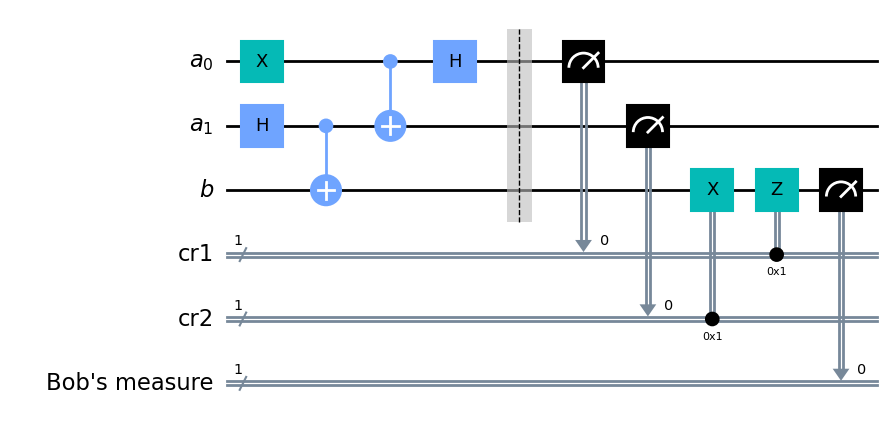

In [25]:
qc = tpCircuit()
qc.measure(2, 2)
qc.draw(output='mpl')

In [26]:
simulator = Aer.get_backend('aer_simulator')
N = 10**3 # Number of shots
job = simulator.run(qc, shots=N)

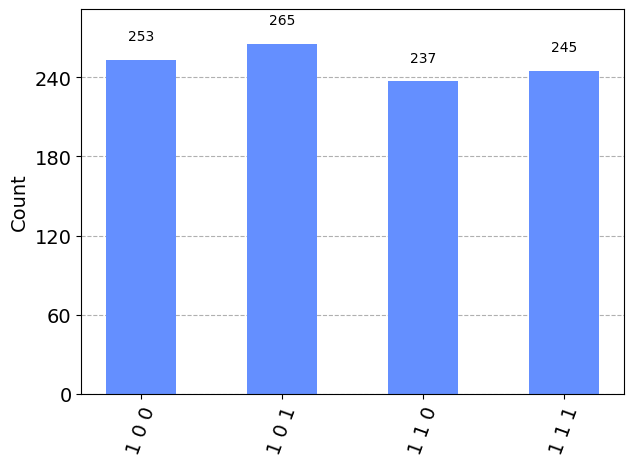

In [27]:
from qiskit.visualization import plot_histogram

counts = job.result().get_counts()
plot_histogram(counts)

As we can see, each string of bits begins with a $1$, which means that we have $100\%$ probability to get the one state.